#### Load Important Libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')

#### Reading the Population and Death Data

In [59]:
# File paths
class_file = 'CLASS.xlsx'
data_file = 'death_population_final_combined.xlsx'

# Read the files
class_df = pd.read_excel(class_file)
data_df = pd.read_excel(data_file)

# Displaying the first few rows of each dataframe to understand the structure
class_df.head()

,Economy,Code,Region,Income group,Lending category
0,Aruba,ABW,Latin America & Caribbean,High income,NaN
1,Afghanistan,AFG,South Asia,Low income,IDA
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,IBRD
3,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD
4,Andorra,AND,Europe & Central Asia,High income,NaN


In [60]:
data_df.head()

,year,country,total_deaths,no_injured,total_damage_000_usd,total_damage_adjusted_000_usd,country_code,population
0,2001,Afghanistan,485.0,20.0,10.0,17.0,AFG,19688632.0
1,2002,Afghanistan,4083.0,1391.0,0.0,0.0,AFG,21000256.0
2,2003,Afghanistan,137.0,4.0,0.0,0.0,AFG,22645130.0
3,2004,Afghanistan,18.0,40.0,0.0,0.0,AFG,23553551.0
4,2005,Afghanistan,570.0,44.0,5050.0,7568.0,AFG,24411191.0


In [61]:
# Merging the data on the country code to combine income group information with the yearly data
income_merged_df = pd.merge(data_df, class_df[['Code', 'Income group']], left_on='country_code', right_on='Code', how='left')

# Calculating the mortality rate per 100,000 people for each year and country
income_merged_df['mortality_rate'] = (income_merged_df['total_deaths'] / income_merged_df['population']) * 1e6

# Grouping the data by income group and year to create an income-wise dataset
income_yearly_df = income_merged_df.groupby(['Income group', 'year']).agg(
    total_deaths=pd.NamedAgg(column='total_deaths', aggfunc='sum'),
    total_population=pd.NamedAgg(column='population', aggfunc='sum'),
).reset_index()

# Calculating the mortality rate per 100,000 people for each income group and year
income_yearly_df['mortality_rate'] = (income_yearly_df['total_deaths'] / income_yearly_df['total_population']) * 1e6

income_yearly_df.head()

,Income group,year,total_deaths,total_population,mortality_rate
0,High income,2001,822.0,1.084684e+09,0.757825
1,High income,2002,1132.0,1.091345e+09,1.037252
2,High income,2003,73153.0,1.098036e+09,66.621707
3,High income,2004,675.0,1.104935e+09,0.610895
4,High income,2005,3248.0,1.112178e+09,2.920396


In [62]:
income_yearly_df.isna().sum()

Income group        0
year                0
total_deaths        0
total_population    0
mortality_rate      0
dtype: int64

In [63]:
# Getting the unique income groups
income_groups = income_yearly_df['Income group'].dropna().unique()

In [64]:
# Filter the data for Afghanistan
selected_group = 'High income'
group = income_yearly_df[income_yearly_df['Income group'] == selected_group]

group.tail()

,Income group,year,total_deaths,total_population,mortality_rate
18,High income,2019,3716.0,1.210313e+09,3.070279
19,High income,2020,7196.0,1.215343e+09,5.920961
20,High income,2021,1987.0,1.214993e+09,1.635401
21,High income,2022,60187.0,1.218911e+09,49.377673
22,High income,2023,463.0,1.219975e+09,0.379516


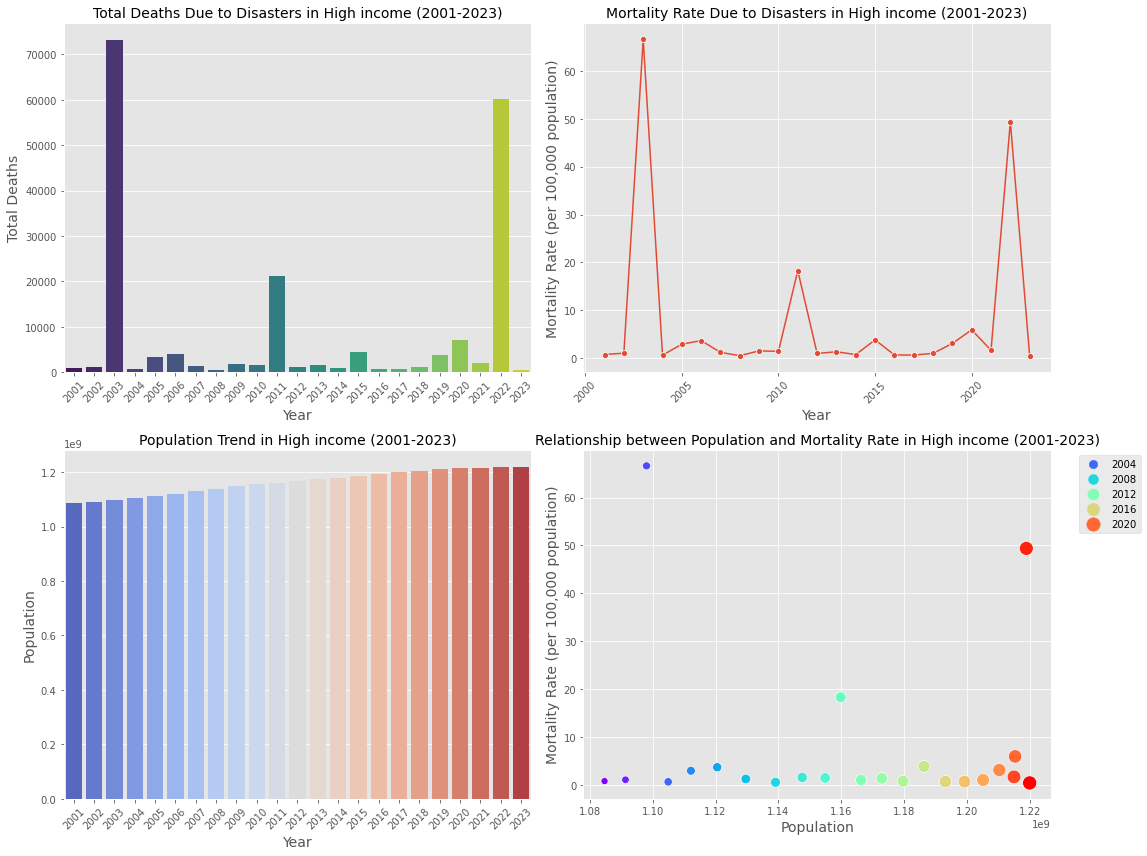

In [65]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar plot to visualize total deaths each year
sns.barplot(data=group, x='year', y='total_deaths', palette='viridis', ax=axs[0, 0])
axs[0, 0].set_title(f'Total Deaths Due to Disasters in {selected_group} (2001-2023)', fontsize = 14)
axs[0, 0].set_xlabel('Year', fontsize = 14)
axs[0, 0].set_ylabel('Total Deaths', fontsize = 14)
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Line plot for mortality rate over the years
sns.lineplot(data=group, x='year', y='mortality_rate', marker='o', ax=axs[0, 1])
axs[0, 1].set_title(f'Mortality Rate Due to Disasters in {selected_group} (2001-2023)', fontsize = 14)
axs[0, 1].set_xlabel('Year', fontsize = 14)
axs[0, 1].set_ylabel('Mortality Rate (per 100,000 population)', fontsize = 14)
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Bar plot to show the population trend over the years
sns.barplot(data=group, x='year', y='total_population', palette='coolwarm', ax=axs[1, 0])
axs[1, 0].set_title(f'Population Trend in {selected_group} (2001-2023)', fontsize = 14)
axs[1, 0].set_xlabel('Year', fontsize = 14)
axs[1, 0].set_ylabel('Population', fontsize = 14)
axs[1, 0].tick_params(axis='x', rotation=45)

# 4. Scatter plot to visualize the relationship between the population and the mortality rate
sns.scatterplot(data=group, x='total_population', y='mortality_rate', hue='year', palette='rainbow', size='year', sizes=(50, 200), ax=axs[1, 1])
axs[1, 1].set_title(f'Relationship between Population and Mortality Rate in {selected_group} (2001-2023)', fontsize = 14)
axs[1, 1].set_xlabel('Population', fontsize = 14)
axs[1, 1].set_ylabel('Mortality Rate (per 100,000 population)', fontsize = 14)
axs[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout
plt.tight_layout()
plt.show()


In [66]:
# Data preparation for Prophet
#pip install prophet-1.1.5-py3-none-win_amd64.whl
from prophet import Prophet
prophet_data = group[['year', 'mortality_rate']]
prophet_data.columns = ['ds', 'y']

# Convert year into proper datetime format
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'].astype(str) + '-12-31')
prophet_data['y'] = prophet_data['y']

# Calculate the median for the entire dataset
# overall_median = prophet_data['y'].median()
# # Replace values in 'y' with this median
# prophet_data.loc[prophet_data['ds'].dt.year == 2022, 'y'] = overall_median

# Filter out the year 2004 from historical data
#prophet_data = prophet_data[~prophet_data['ds'].dt.year.isin([2004])]
# Assuming your DataFrame is named 'prophet_data' and the target column is 'y'
#prophet_data['y'] = prophet_data['y'].replace(0, 0.1)
prophet_data.tail()

,ds,y
18,2019-12-31,3.070279
19,2020-12-31,5.920961
20,2021-12-31,1.635401
21,2022-12-31,49.377673
22,2023-12-31,0.379516


For Prophet:
The data is structured in a DataFrame with two columns:

ds: Represents the date (timestamp) set to the end of each year.

y: The mortality rate to be forecasted.

Now, let's move on to the Prophet forecasting:

In [67]:
# Define disasters as holidays
disasters = pd.DataFrame({
    'holiday': 'disaster',
    'ds': pd.to_datetime(['2003-12-31', '2011-12-31', '2022-12-31']),
    'lower_window': 0,
    'upper_window': 0,
})

# Initialize the Prophet model with additional parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=disasters,
    seasonality_mode='multiplicative',
    #seasonality_mode='additive',
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=160,
    #holidays_prior_scale=160,
    mcmc_samples=0
)
# Add a custom yearly seasonality
#model.add_seasonality(name='yearly', period=365.25, fourier_order=12)  # Replace `N` with the desired number of Fourier terms

model.fit(prophet_data)
# changepoint_prior_scale=2
# Forecasting for 2023 to 2025
future_dates = model.make_future_dataframe(periods=7, freq='Y')
forecast = model.predict(future_dates)

13:38:03 - cmdstanpy - INFO - Chain [1] start processing
13:38:04 - cmdstanpy - INFO - Chain [1] done processing


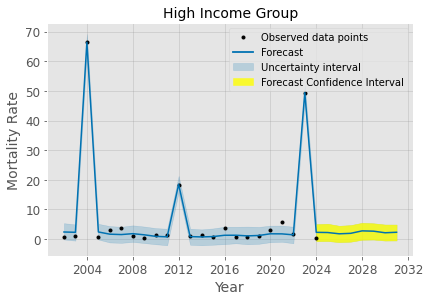

In [68]:
# Plot the forecast
fig = model.plot(forecast, figsize=(6, 4), uncertainty=True)

# Highlight the prediction (2024-2030) with a different color for the confidence interval
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 where=(forecast['ds'] >= '2023-12-31'), color='yellow', alpha=0.8, label='Forecast Confidence Interval')
# Customize the plot
ax = fig.gca()
ax.tick_params(axis='both', labelsize=12)  # Adjust labelsize as needed
ax.set_xlabel('Year', fontsize=14)  # Set the X-axis label
ax.set_ylabel('Mortality Rate', fontsize=14)  # Set the Y-axis label
ax.set_title('High Income Group', fontsize=14)  # Set the title
#ax.set_ylim(-5, 40)

# Add legend
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(1.8)  # Set the linewidth of the legend lines
plt.show()

# Save the figure
fig.savefig(f'mortality_rate_forecast_{selected_group}.pdf', format='pdf', bbox_inches='tight')
fig.savefig(f'mortality_rate_forecast_{selected_group}.png', format='png', dpi=600, bbox_inches='tight')

In [69]:
# Print the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7))

           ds      yhat  yhat_lower  yhat_upper
23 2024-12-31  2.229354   -0.619428    5.170247
24 2025-12-31  1.799067   -1.002592    4.483612
25 2026-12-31  1.956077   -0.848293    4.712913
26 2027-12-31  2.789036   -0.187733    5.496428
27 2028-12-31  2.684334   -0.130868    5.325000
28 2029-12-31  2.148420   -0.470492    4.904090
29 2030-12-31  2.318343   -0.430506    4.897655


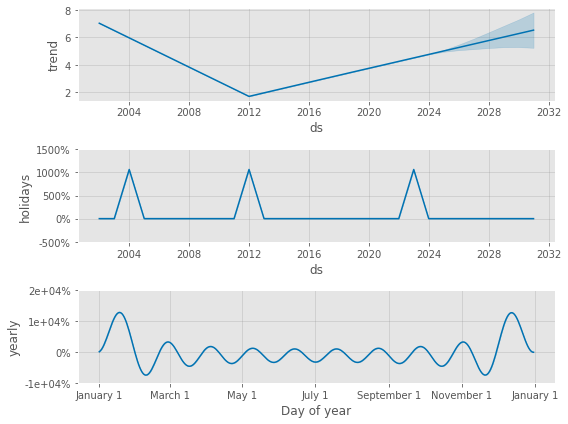

In [70]:
# Displaying components of the forecast
fig2 = model.plot_components(forecast, figsize=(8, 6))

In [71]:
# Adjust the last 7 'yhat_lower' entries to zero if they are negative and calculate the means for those entries
forecast.loc[forecast.index[-7:], 'yhat_lower'] = forecast['yhat_lower'][-7:].apply(lambda x: max(x, 0))

# Now calculate the mean of the 'yhat_lower' and 'yhat_upper' for the last 7 entries
mean_lower_last_7 = forecast['yhat_lower'][-7:].mean()
mean_upper_last_7 = forecast['yhat_upper'][-7:].mean()

mean_lower_last_7, mean_upper_last_7

(0.0, 4.998563556653234)

In [72]:
print(forecast[['yhat']].tail(7))

        yhat
23  2.229354
24  1.799067
25  1.956077
26  2.789036
27  2.684334
28  2.148420
29  2.318343


#### BenchMark Strategy 1

In [73]:
# Calculate historical mean
historical_mean = income_yearly_df['mortality_rate'].mean()
print(f"Historical Mean Mortality Rate: {historical_mean}")

# Selecting only the years 2024 to 2030 for the calculation
forecast_data = forecast[(forecast['ds'] >= "2024-12-31") & (forecast['ds'] <= "2030-12-31")]

# Calculate forecast mean
forecast_mean = forecast_data['yhat'].mean()
print(f"Forecast Mean Mortality Rate: {forecast_mean}")

# Check for reduction
reduction_25 = historical_mean * 0.75
reduction_50 = historical_mean * 0.50

print(f"25% Reduction Threshold: {reduction_25}")
print(f"50% Reduction Threshold: {reduction_50}")

# Check for 25% Reduction
if forecast_mean <= reduction_25:
    print("Yes:25% reduction")
else:
    print("No: 25% reduction")

# Check for 50% Reduction
if forecast_mean <= reduction_50:
    print("Yes:50% reduction")
else:
    print("No: 50% reduction")


Historical Mean Mortality Rate: 9.2163993173272
Forecast Mean Mortality Rate: 2.274947298058934
25% Reduction Threshold: 6.9122994879954
50% Reduction Threshold: 4.6081996586636
Yes:25% reduction
Yes:50% reduction


#### BenchMark Strategy 2

To set a benchmark for a significant decrease in the mortality rate, we can calculate the average year-on-year change in the mortality rate for the past data. This average change will serve as our benchmark. If the average (or median) year-on-year change in the forecasted data is lower than the benchmark, it indicates a significant decrease in mortality rates compared to historical trends.

Here's how we can calculate this benchmark:

- Calculating Year-on-Year Changes (Historical Data): For the historical data, the year-on-year change in mortality rate is calculated by subtracting the mortality rate of the previous year from that of the current year.These changes provide insight into how the mortality rate has evolved annually.

- Set the Benchmark: Calculate the average of these year-on-year change. Use this average change as the benchmark for a significant decrease.

- Calculating Year-on-Year Changes (Forecasted Data): Similar to the historical data, the year-on-year change in the forecasted mortality rate is calculated.

- Comparison with Benchmark: The average (or median) of these forecasted year-on-year changes is then compared with the benchmark. If the average (or median) year-on-year change in the forecasted data is lower than the benchmark, it indicates a significant decrease in mortality rates compared to historical trends.

In [74]:
# Calculate year-on-year decrease in mortality rate
income_yearly_df['year_on_year_change'] = income_yearly_df['mortality_rate'].diff()

# Compute the average decrease (ignoring the first year as it has no previous year data)
benchmark = income_yearly_df['year_on_year_change'][1:].mean()
print(benchmark)

0.19342755598695013


In [75]:
# Calculate the year-on-year decrease in forecasted mortality rate
forecast_data['year_on_year_change'] = forecast_data['yhat'].diff()

# Display the results
forecast_data[['ds', 'yhat', 'year_on_year_change']]

,ds,yhat,year_on_year_change
23,2024-12-31,2.229354,NaN
24,2025-12-31,1.799067,-0.430286
25,2026-12-31,1.956077,0.157009
26,2027-12-31,2.789036,0.832960
27,2028-12-31,2.684334,-0.104703
28,2029-12-31,2.148420,-0.535914
29,2030-12-31,2.318343,0.169924


In [76]:
# Calculate the average decrease across all forecasted years
# Ignoring the first entry as it does not have a preceding year for comparison
average_forecast = forecast_data['year_on_year_change'][1:].mean()
print(average_forecast)

0.014831592089209034
